# Predicting crimes resolutions

Our objective is to predict the resolution of a crime based on victim's features, geographical and temporary data, and some other details like the weapon used and the type of agency where the crime was reported.

# Variables to use
### The complete set of variables could be found on the 'EDA' notebook. There we also specified the reasons why we use this subset of variables

## Inputs

<table>
    <tr>
        <th style="text-align: center;">Variable</td>
        <th style="text-align: center;">Description</td>
    </tr>
    <tr>
        <td style="text-align: center;">Agency Type</td>
        <td style="text-align: center;">The type of agency</td>
    </tr>
    <tr>
        <td style="text-align: center;">State</td>
        <td style="text-align: center;">The name of the state where the homicide happened</td>
    </tr>
    <tr>
        <td style="text-align: center;">Year</td>
        <td style="text-align: center;">The year of the homicide</td>
    </tr>
    <tr>
        <td style="text-align: center;">Month</td>
        <td style="text-align: center;">The month of the homicide</td>
    </tr>
    <tr>
        <td style="text-align: center;">Crime Type</td>
        <td style="text-align: center;">The type of crime</td>
    </tr>
    <tr>
        <td style="text-align: center;">Victim Sex</td>
        <td style="text-align: center;">The sex of the victim</td>
    </tr>
    <tr>
        <td style="text-align: center;">Victim Age</td>
        <td style="text-align: center;">The age of the victim</td>
    </tr>
    <tr>
        <td style="text-align: center;">Victim Race</td>
        <td style="text-align: center;">The race of the victim</td>
    </tr>
    <tr>
        <td style="text-align: center;">Weapon</td>
        <td style="text-align: center;">The weapon used</td>
    </tr>
</table>

## Output

<table>
    <tr>
        <td style="text-align: center;">**Crime Solved**</td>
        <td style="text-align: center;">Indicates whether the crime has been solved or not</td>
    </tr>
</table>

# The metric

Our client said "We don't want to create fake hope"..
It's preferable to say 'The crime won't be solved' and then it's solved, than say 'The crime will be solved' and then not.

So, the most important thing is not to say 'Yes' if a crime was not solved.

**We need to minimize the False positives:**
True predictions that are False.

The appropiate metric for this situations is **Precision: TP / (TP - FP)**

Crimes predicted as 'solved' that were solved / Crimes predicted as 'solved'.


The best value for this metric is 1 and the worst value is 0.

# 1) Preprocessing:
## -Dataset extraction.
## -Unused columns removal.
## -Used columns rename.

In [78]:
import numpy as np
import pandas as pd
import zipfile

# Extract the dataset
zipfile.ZipFile(file='dataset.zip', mode='r').extractall()

ds = pd.read_csv('dataset.csv')

# Drop unused columns
ds.drop(axis=1, inplace=True, labels=['Record ID', 'Agency Code','Agency Name', 'City', 'Incident', 
        'Perpetrator Sex', 'Perpetrator Age', 'Perpetrator Race', 'Perpetrator Ethnicity', 
        'Victim Ethnicity', 'Relationship', 'Victim Count', 'Perpetrator Count', 'Record Source'])

# Column rename
BETTER_COLUMNS_NAMES = {
    'Agency Type': 'agency_type',
    'State': 'state',
    'Year': 'year',
    'Month': 'month',
    'Crime Type': 'crime_type',
    'Crime Solved': 'crime_solved',
    'Victim Sex': 'victim_sex',
    'Victim Age': 'victim_age',
    'Victim Race': 'victim_race',
    'Weapon': 'weapon',
}

ds.rename(columns=BETTER_COLUMNS_NAMES, inplace=True)

ds.columns

/home/nacho/.local/share/virtualenvs/machine-learning-OxPy3u81/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['agency_type', 'state', 'year', 'month', 'crime_type', 'crime_solved',
       'victim_sex', 'victim_age', 'victim_race', 'weapon'],
      dtype='object')

## -Output variable balance

In [79]:
from sklearn.utils import shuffle

# Left the crime_solved='Yes' rows at the end
ds.sort_values(by='crime_solved', inplace=True)

# Drop rows to get the same number of examples of 'Yes' and 'No'
ds.drop(ds.index[-257890:], inplace=True)

ds = shuffle(ds)

print(ds.crime_solved.value_counts())

Yes    190282
No     190282
Name: crime_solved, dtype: int64


## -Splitting the dataset into train, test and validation

In [80]:
from sklearn.model_selection import train_test_split

# 60% train, 30% test, 10% validation
train, not_train = train_test_split(ds, test_size=0.4)
validation, test = train_test_split(not_train, test_size=0.75)

# 2) Defining a generic function to evaluate the different models

In [172]:
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix
from matplotlib import pyplot as plt
%matplotlib inline
scaler = StandardScaler()

def evaluate_model(model, extract_inputs_outputs, include_validation=False):
    sets = [('train', train), ('test', test)]
    if (include_validation):
        sets.append(('validation', validation))
    
    for set_name, set_data in sets:
        inputs, outputs = extract_inputs_outputs(set_data)

        predictions = model.predict(inputs)

        predictions = predictions.astype(np.float64).round()
        
        print('Model evaluation on dataset:' + set_name)
        
        print('Accuracy score:', accuracy_score(outputs, predictions))
        
        print('Precision score:', precision_score(outputs, predictions))
        
        plt.figure(figsize=(3,4))
        
        plt.xticks([0, 1], ['not solved', 'solved'], rotation=45)
        plt.yticks([0, 1], ['not solved', 'solved'])
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

        plt.title(set_name)

        plt.imshow(
            confusion_matrix(outputs, predictions),
            cmap=plt.cm.Blues,
            interpolation='nearest',
        )

        plt.show()
        

# 3) Models:

# First attempt: Logistic Regression

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

(The main challenge here is to handle the categorical variables. This is a common preprocessing step where we have to convert any possible text value into a new column. It's necessary since the Logistic Regression only handles numbers)

In [177]:
import datetime as d

def lr_extract_inputs_outputs(dataset):
    ds = dataset.copy()
    
    # month format
    ds.month = ds.month.apply(lambda x: d.datetime.strptime(x[:3], '%b').month)
    
    # agency type
    for agency_type in ds.agency_type.unique():
        ds[agency_type.lower().replace(' ', '_')] = (ds.agency_type == agency_type)
    ds.drop(columns=['agency_type'], inplace=True)
    
    # state
    for state in ds.state.unique():
        ds[state.lower().replace(' ', '_')] = (ds.state == state)
    ds.drop(columns=['state'], inplace=True)
        
    # crime type
    for crime_type in ds.crime_type.unique():
        ds[crime_type.lower().replace(' ', '_')] = (ds.crime_type == crime_type)
    ds.drop(columns=['crime_type'], inplace=True)
        
    # victim sex
    ds = ds[ds.victim_sex != 'Unknown']
    for victim_sex in ds.victim_sex.unique():
        ds[victim_sex.lower().replace(' ', '_')] = (ds.victim_sex == victim_sex)
    ds.drop(columns=['victim_sex'], inplace=True)
        
    # victim age
    ds = ds[ds.victim_age != 998]

    # victim race
    ds = ds[ds.victim_race != 'Unknown']
    for victim_race in ds.victim_race.unique():
        ds[victim_race.lower().replace(' ','_')] = (ds.victim_race == victim_race)
    ds.drop(columns=['victim_race'], inplace=True)

    # weapon
    ds = ds[ds.weapon != 'Unknown']

    for weapon in ds.weapon.unique():
        ds[weapon.lower().replace(' ', '_')] = (ds.weapon == weapon)
    ds.drop(columns=['weapon'], inplace=True)
    
    # crime_solved
    ds['crime_solved'] = (ds.crime_solved == 'Yes')
    
    inputs = ds.drop(columns=['crime_solved'])
    outputs = ds.crime_solved
    
    return [scaler.fit_transform(inputs).astype(np.float64), outputs.values]

In [181]:
lr_model = LogisticRegression()

In [182]:
inputs, outputs = lr_extract_inputs_outputs(train)

lr_model.fit(inputs, outputs)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Model evaluation on dataset:train
Accuracy score: 0.749374292212674
Precision score: 0.738296191769394


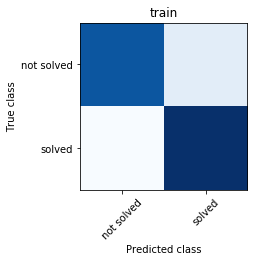

Model evaluation on dataset:test
Accuracy score: 0.695926557927149
Precision score: 0.6836289771831825


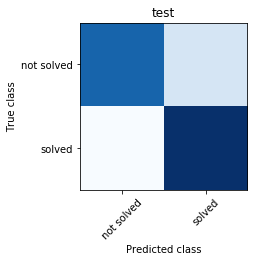

Model evaluation on dataset:validation
Accuracy score: 0.7124896419693116
Precision score: 0.6991159755840876


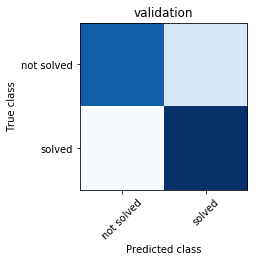

In [183]:
evaluate_model(lr_model, lr_extract_inputs_outputs, include_validation=True)

## Conclusions:
The logistic regression isn't doing it very well. The precission score for the test set was 0.68 and we can see on the confussion matrix that it's getting many False Positives. Clearly, we can't present this model to our client.

# 2nd model: Decision Trees

(Here we faced the problem of converting every text value into a numeric one. In the case of the 'state' column it was a big work to map the 50 different values. Maybe a better approach would be to create the map in a dynamic way, as we can get the possible values of a column by ds.column_name.unique(). This could be an improvement for the future work)

In [157]:
import datetime as d

def dt_extract_inputs_outputs(dataset):
    ds = dataset.copy()

    # month format
    ds.month = ds.month.apply(lambda x: d.datetime.strptime(x[:3], '%b').month)
    
    # victim sex
    ds = ds[ds.victim_sex != 'Unknown']

    # victim age
    ds = ds[ds.victim_age != 998]

    # victim race
    ds = ds[ds.victim_race != 'Unknown']

    # weapon
    ds = ds[ds.weapon != 'Unknown']

    ds['weapon'] = ds.weapon.map({'Blunt Object': 1, 'Rifle': 2, 'Knife': 3,
       'Gun': 4, 'Fire': 5, 'Suffocation': 6, 'Strangulation': 7,
       'Explosives': 8, 'Drugs': 9, 'Drowning': 10, 'Poison': 11, 'Fall': 12,
       'Handgun': 13, 'Firearm': 14, 'Shotgun': 15})
    
    # agency type
    ds['agency_type'] = ds.agency_type.map({'Municipal Police': 1, 'Sheriff': 2, 'County Police': 3, 
                        'State Police': 4, 'Special Police': 5, 'Tribal Police': 5, 'Regional Police': 6})
    
    # crime_solved
    ds['crime_solved'] = (ds.crime_solved == 'Yes')
    
    
    ds['victim_race'] = ds.victim_race.map({'Black': 1, 'White': 2,
                                            'Asian/Pacific Islander': 3,
                                            'Native American/Alaska Native':4})
    
    # state
    ds['state'] = ds.state.map({'Pennsylvania': 1, 'Florida': 2, 'Illinois': 3, 'Louisiana': 4, 'California': 5,
       'New Jersey': 6, 'Texas': 7, 'Tennessee': 8, 'Michigan': 9, 'Maryland': 10,
       'New York': 11, 'North Carolina': 12, 'Missouri': 13, 'Ohio': 14, 'Georgia': 15,
       'Oklahoma': 16, 'Nevada': 17, 'West Virginia': 18, 'District of Columbia': 19,
       'Virginia': 20, 'Colorado': 21, 'Kentucky': 22, 'Minnesota': 23, 'New Mexico': 24,
       'Arizona': 25, 'Idaho': 26, 'Oregon': 27, 'Arkansas': 28, 'Indiana': 29, 'Wisconsin': 30,
       'Mississippi': 31, 'Connecticut': 32, 'Washington': 33, 'Maine': 34,
       'Massachusetts': 35, 'Iowa': 36, 'South Carolina': 37, 'Alabama': 38, 'Nebraska': 39,
       'Alaska': 40, 'Utah': 41, 'Delaware': 42, 'Hawaii': 43, 'Vermont': 44, 'Wyoming': 45,
       'Rhodes Island': 46, 'Kansas': 47, 'Montana': 48, 'New Hampshire': 49,
       'North Dakota': 50, 'South Dakota': 51})
    
    # crime solved
    ds['crime_type'] = ds.crime_type.map({'Murder or Manslaughter': 1, 'Manslaughter by Negligence': 2})
    
    # victim sex
    ds['victim_sex'] = ds.victim_sex.map({'Male': 1, 'Female': 2})
    
    inputs = ds.drop(columns=['crime_solved'])
    outputs = ds.crime_solved
    
    return [inputs.values, outputs.values]

In [167]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(max_depth=15);

inputs, outputs = dt_extract_inputs_outputs(train)
dt_classifier.fit(inputs, outputs)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Model evaluation on dataset:train
Accuracy score: 0.8237883156802848
Precision score: 0.7837105775682885


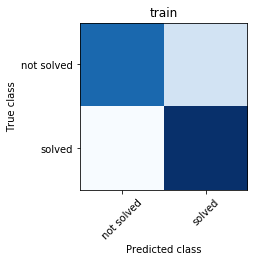

Model evaluation on dataset:test
Accuracy score: 0.7913230822028808
Precision score: 0.7553661512084144


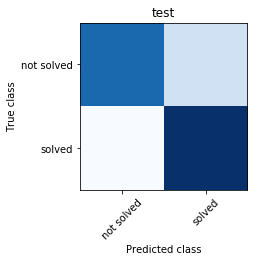

Model evaluation on dataset:validation
Accuracy score: 0.788010400891505
Precision score: 0.7520363331194155


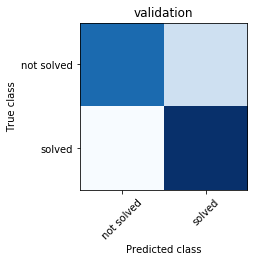

In [168]:
evaluate_model(dt_classifier, dt_extract_inputs_outputs, include_validation=True)

In [ ]:
import graphviz
from sklearn.tree import export_graphviz

def graph_tree(tree):
    graph_data = export_graphviz(
        tree, 
        out_file=None, 
        feature_names=['agency_type', 'state', 'year', 'month', 'crime_type',
                    'victim_sex', 'victim_age', 'victim_race', 'weapon'],
        class_names=[' Not solved', 'Solved'],
        filled=True, 
        rounded=True,  
        special_characters=True,
    )
    graph = graphviz.Source(graph_data)  
    # graph.render('rendered_tree')
    return graph

graph_tree(dt_classifier)

## Feature importances

<BarContainer object of 9 artists>

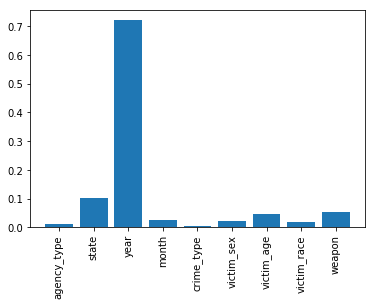

In [155]:
feature_importances = dt_classifier. feature_importances_

plt.xticks(rotation='vertical')
plt.bar(x=['agency_type', 'state', 'year', 'month', 'crime_type', 'victim_sex', 
           'victim_age', 'victim_race', 'weapon'], height=feature_importances)

## Conclusions
The model is giving an extremely big importance to the 'year' variable, followed from afar by the 'state' variable. We don't know how good is this situation. We tried to use a scaler to 'normalize' the values for the year (pretty higher than the other variables) but the result was the same.

Related to the precission metric, the model achieved a better score than the Logistic Regression (**0.75** for test and validation). 

This score was achieved with a **max_depth** of 15. We choose that number after trying with many and seeing that: **1)** a lower depth causes worst scores and **2)** a bigger depth causes overfitting (only improves predictions on train)

# 3rd Model: Neural Network

In [184]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout
from sklearn.preprocessing import StandardScaler

In [200]:
nn_model = Sequential([   
    Dense(500, input_shape=(84,)),
    Activation('tanh'),
    
    Dropout(0.2),

    Dense(500),
    Activation('tanh'),
    
    Dense(1),
    Activation('sigmoid'),
])

In [201]:
nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [ ]:
scaler = StandardScaler()
inputs, outputs = lr_extract_inputs_outputs(train)
inputs_test, outputs_test = lr_extract_inputs_outputs(test)
history = nn_model.fit(
    inputs,
    outputs,
    epochs=10,
    batch_size=200,
    validation_data=(
        inputs_test,
        outputs_test,
    )
)

In [ ]:
evaluate_model(nn_model, lr_extract_inputs_outputs, include_validation=True)